# Import

In [4]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Test Env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 145.39it/s]


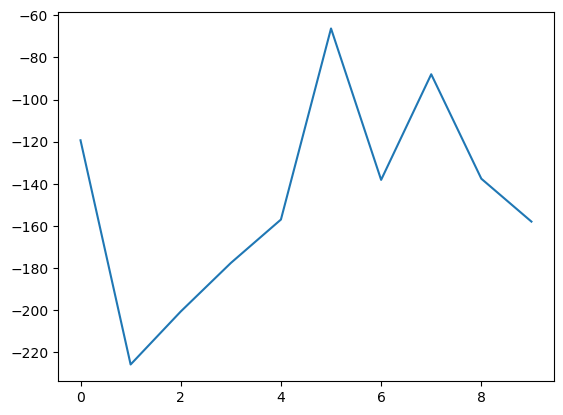

In [5]:
env = gym.make('LunarLander-v2')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# DQN

In [23]:
class DQN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_size, output_size, hidden_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super().__init__()
        # self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

# Replay Memory

In [24]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory():
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        args = [state, action,reward, next_state, done]
        names = ['state', 'action', 'reward', 'next_state', 'done']
        #NOTE: make sure the arguments are tensor and shape = (1,-1)
        for arg, name in zip(args, names):
            assert torch.is_tensor(arg), f'{name} to memory replay must be a tensor'
            assert len(arg.shape) == 2, f'{name} shape must be in the shape (1, -1)'
        
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''
        @params: 
            batch_size: int
        @return:
            states: torch.tensor
            actions: torch.tensor
            rewards: torch.tensor
            next_states: torch.tensor
            done: torch.tensor
        '''
        if batch_size > len(self.memory): return None
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)


        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [25]:
#Test memory
memory = ReplayMemory(capacity=10)
env = gym.make('LunarLander-v2')
obs, info = env.reset()
observation_n = len(obs)
action_n = env.action_space.n

for _ in range(10):
    state = torch.rand((1,observation_n))
    next_state = torch.rand((1,observation_n))
    action = torch.randint(0,action_n, (1,1))
    reward = torch.randint(-10,10,(1,1))
    done = torch.tensor([random.choice([True, False])], dtype = torch.int32).unsqueeze(0)

    memory.push(state, action, reward, next_state, done)

states, actions, rewards, next_states, dones = memory.sample(5)
print(states)
print(actions)
print(rewards)
print(next_states)
print(dones)
env.close()

tensor([[0.0866, 0.3238, 0.6501, 0.3248, 0.9368, 0.7643, 0.0305, 0.2673],
        [0.7233, 0.3145, 0.3118, 0.5591, 0.7119, 0.5413, 0.2952, 0.7639],
        [0.9736, 0.2367, 0.8142, 0.2173, 0.1707, 0.7651, 0.7933, 0.1644],
        [0.6606, 0.6933, 0.5630, 0.2335, 0.1617, 0.6405, 0.1198, 0.7725],
        [0.4742, 0.4207, 0.3761, 0.7273, 0.8850, 0.5037, 0.8226, 0.4503]])
tensor([[0],
        [1],
        [1],
        [3],
        [1]])
tensor([[ 0],
        [-2],
        [-1],
        [-5],
        [ 2]])
tensor([[0.5876, 0.6966, 0.8175, 0.3951, 0.0796, 0.4643, 0.7297, 0.9859],
        [0.4183, 0.2317, 0.3337, 0.5656, 0.2073, 0.7571, 0.6563, 0.4744],
        [0.2057, 0.4547, 0.9967, 0.7512, 0.6406, 0.4472, 0.1102, 0.4695],
        [0.1639, 0.2552, 0.1994, 0.9068, 0.1038, 0.2793, 0.1284, 0.3350],
        [0.7067, 0.4345, 0.1968, 0.3911, 0.7633, 0.6586, 0.7286, 0.0908]])
tensor([[1],
        [1],
        [0],
        [0],
        [0]], dtype=torch.int32)


# Hyperparams

# Agent

In [26]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
C = 4


class Agent():
    def __init__(self, state_size, action_size, hidden_size = 64, 
                memory_cap = BUFFER_SIZE, batch_size = BATCH_SIZE, lr = LR,
                gamma = GAMMA, c = C, tau = TAU, seed = 0, debug = False, ):

        self.state_size = state_size
        self.action_size = action_size
        self.memory_cap = memory_cap
        self.batch_size = batch_size
        self.lr = LR
        self.gamma = gamma
        self.c = C
        self.tau = TAU

        #networks
        self.policy_net = DQN(state_size, action_size, hidden_size = hidden_size)
        self.target_net = DQN(state_size, action_size, hidden_size = hidden_size)

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr = lr)
        self.criterion = nn.MSELoss()

        self.memory = ReplayMemory(memory_cap)
        self.step_count = 0
        self.sync_count = 0
        self.exploit_count = 0
        self.explore_count = 0


        self.debug = debug
    
    def get_action(self, state, eps):
        '''
        @params:
            state: torch.tensor
            eps: float, set ep = 0, returns best action from policy net
        @return:
            action: torch.tensor, shape = (1,1)
        '''
        assert torch.is_tensor(state), 'state must be a tensor'
        assert len(state.shape) == 2, 'state shape must be (1, -1)'

        p = random.random()
        #exploit
        if p > eps:
            self.exploit_count += 1
            self.policy_net.eval()
            with torch.no_grad():
                action = self.policy_net(state).to(torch.int64).max(1).indices.reshape(1,1)
            self.policy_net.train()
            if self.debug:
                print('expoit action')
            return action
        else:
            self.explore_count += 1
            if self.debug:
                print('explore action')
            return torch.tensor([random.choice(range(self.action_size))], dtype = torch.int64).view(1,1)
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.step_count += 1

        transitions = self.memory.sample(self.batch_size)
        #if transitions is None, not enough memory batch to learn, skip it
        if transitions != None:
            self.learn(transitions)
            #perform soft update if it's time
            self._soft_update()
    
    def _soft_update(self):
        if self.step_count % self.c == 0:
            for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                target_param.data.copy_(self.tau*policy_param.data + (1.0-self.tau)*target_param.data)
            self.sync_count += 1
        
    def learn(self, transitions):
        (states, actions, rewards, next_states, dones) = transitions

        #Calculate TD 
        target_net_output = self.target_net(next_states).detach().max(1).values.unsqueeze(1)
        next_state_values = rewards + self.gamma * target_net_output * (1 - dones)

        state_values = self.policy_net(states).gather(1, actions)
        loss = F.mse_loss(state_values, next_state_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.debug:
            print(f'states = {states.shape},', states)
            print(f'actions = {actions.shape},', actions)
            print(f'rewards = {rewards.shape},', rewards)
            print(f'next states = {next_states.shape},', next_states)
            print(f'dones = {dones.shape},', dones)
            print(f'state values {state_values.shape} = ', state_values)
            print(f'next state values {next_state_values.shape} = ', next_state_values)
            print(loss.item())

        self._soft_update()
    
    def __str__(self):
        params = f'sync_count={self.sync_count}'

In [27]:
#Test agent class
agent = Agent(8,4, batch_size = 5)
sample_state = torch.rand((1,8))

agent.memory = memory

action = agent.get_action(sample_state,0.0)
print(action)
action = agent.get_action(sample_state, 0.99)
print(action)

transitions = memory.sample(5)

agent.learn(transitions)



tensor([[0]])
tensor([[2]])


# Training loop

In [28]:
training_epochs = 1000
max_step = 1000
max_ep = 1.0
min_ep = 0.01
decay_ep =0.995
seed = 0

env = gym.make('LunarLander-v2')
obs,info = env.reset()
state_size = len(obs)
action_size = env.action_space.n

agent = Agent(state_size, action_size)

scores = []
score_window = deque(maxlen = 100)
epsilon = max_ep

loop = tqdm(range(training_epochs))
for epoch in loop:

    state, info = env.reset(seed = seed)
    state_tensor = torch.tensor([state])
    total_reward = 0
    done = False
    epsilon = max(min_ep, epsilon *decay_ep)

    for t in range(max_step):
        action_tensor = agent.get_action(state_tensor, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action[0].item())
        total_reward += reward

        if terminated or truncated:
            done = True

        next_state_tensor = torch.tensor(next_state,dtype = torch.float32).unsqueeze(0)
        reward_tensor = torch.tensor([reward],dtype = torch.float32).unsqueeze(0)
        done_tensor = torch.tensor([done],dtype = torch.int32).unsqueeze(0)

        agent.step(state_tensor, action_tensor, reward_tensor, next_state_tensor, done_tensor)
        if done:
            break

    score_window.append(total_reward)
    loop.set_description(f'e={epoch}, epsilon={epsilon}, avg_reward={np.mean(score_window)}, sync count = {agent.sync_count}, explore ={agent.explore_count}, exploit = {agent.exploit_count}')




e=150, epsilon=0.46912134373457726, avg_reward=-393.81879004371956, sync count = 6688, explore =9360, exploit = 4079:  15%|█▌        | 151/1000 [00:10<00:59, 14.26it/s]


KeyboardInterrupt: 